In [1]:
#### load packages, *.h5 folder and exp.h5 file location
%matplotlib widget

from essential_func import *
qgrid2 = np.hstack([np.arange(0.005, 0.0499, 0.001), np.arange(0.05, 0.099, 0.002), np.arange(0.1, 3.2, 0.005)])

samples_csv                = 'data_directory.csv'
default_sample_dir         = 'Mar-2023-Sample#1971'      # 'July-2021-Sample#6'    '21-Nov'   'July-sorted'   '20-Dec'    '22-Oct'   'Oct-2022-1971'   'Mar-2023-Sample#1948'
csv_and_code_abs_directory = '/Users/bashit.a/Documents/Alzheimer/Codes/'

dropdown_name, dropdown_name_list, cwd, exp_folder = change_python_path(dropdown_name = default_sample_dir, csv_file_location = csv_and_code_abs_directory, samples_csv = samples_csv)

Python directory is set to load samples from : Mar-2023-Sample#1971


Output()

None

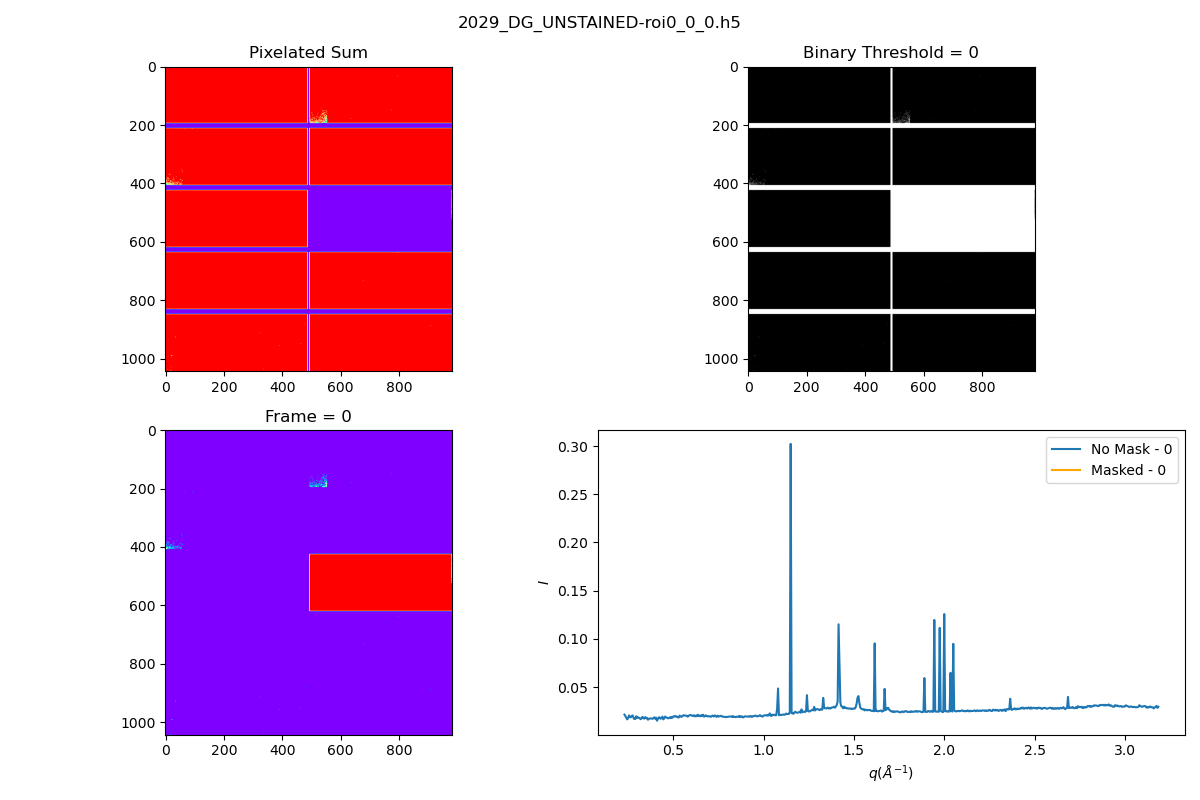

In [2]:
### load pixalated sum either directly from h5 file or already stored pixalted sum npz file -------- ##### (Independent Cell) - loading from file
%matplotlib widget

## specs/Slider Properties
AMIN_DEFAULT_VALUE = 0       # minimum value for the pixalated sum

frame_w = ipywidgets.IntSlider(value=0, min=0, max=3600, step=1, description = 'Frame', continuous_update=False, layout=ipywidgets.Layout(width='50%'))
a_min_w = ipywidgets.fixed(value=AMIN_DEFAULT_VALUE)
a_max_w = ipywidgets.FloatSlider(value=50, min=0,     max=100, step=1, description = 'a_max', continuous_update=False, layout=ipywidgets.Layout(width='50%'))
thr_w   = ipywidgets.IntSlider(value=AMIN_DEFAULT_VALUE,    min=AMIN_DEFAULT_VALUE, max=10, step=1, description = 'thr', continuous_update=False, layout=ipywidgets.Layout(width='50%'))
ipywidgets.jslink((a_max_w,'value'),(thr_w,'max'))           # make sure threshold's maximum value doesn't exceed a_max value

f, axs = plt.subplots(nrows=2,ncols=2,figsize=(12,8), )


def waxs_thresholding(file, a_min, a_max, thr, frame):
    global f, axs
    f.num=f'{file}'
    
    # spec
    dset_waxs_sum = loading_dset_waxs_sum(file, load_from = 'npz')

    ## you don't need azimuthal averaging of the original file to do masking
    AMAX_DEFAULT_VALUE = np.median(dset_waxs_sum) ; 
    AMAX_MIN_VALUE = dset_waxs_sum.min() ; 
    AMAX_MAX_VALUE = np.percentile(dset_waxs_sum, 99);  
    AMAX_SLIDER_STEP = 100;    # maximum values for the pixalated sum
    # valid_range_min, valid_range_max = (0,10)   # just for WAXS Display purpose

    n_patterns = list(map(lambda x,y: x*y, *zip(width_height(file))))[0]   # calculate number of frames
    frame_w.max = n_patterns-1
    
    a_max_w.max   = AMAX_MAX_VALUE
    a_max_w.step  = AMAX_SLIDER_STEP

    thr_w.max = a_max_w.value

    # load waxs frame data 
    with h5py.File(file,'r') as hdf:
        dset_waxs = hdf.get(f'{h5_top_group(file)}/primary/data/pilW2_image')         # waxs data read from h5 file
        dset_waxs = np.array(dset_waxs[frame])
        
    args = (dset_waxs_sum, a_min, a_max, thr)
    dset_waxs_thr, gray_img, thr_fr_img = threshold_patch_one_frame(dset_waxs, args = args)
    
    #### plot thresholded pixalated sum
    axs[0,0].clear()
    im = axs[0,0].imshow(dset_waxs_thr, cmap = 'rainbow')       #plt.colorbar(im, fraction=0.046, pad=0.04)  

    axs[0,0].set_title('Pixelated Sum')

    #### plot global thresholding 
    axs[0,1].clear()
    im = axs[0,1].imshow(gray_img, cmap='gray')       
    axs[0,1].set_title(f'Binary Threshold = {thr}')

    axs[1,0].clear() 
    axs[1,1].clear()
    patching(file, frame, qgrid2, args=args, axes = (f,[axs[1,0], axs[1,1]]), method = 'thresholding', exp_folder = exp_folder  )

    print('File = ', file, 'a_min = ', a_min, 'a_max = {:0.2f}'.format(a_max), 'thr = ', thr)

### change dropdown_file lists when directory is changed
dropdown_dir   = ipywidgets.Dropdown(options= dropdown_name_list,           value = default_sample_dir,              description='Folder ',       disabled=False)
dropdown_file  = ipywidgets.Dropdown(options= cwd_files_search_with(seek_str='.h5', search_where = 'end', directory = cwd), value = cwd_files_search_with(seek_str='.h5', search_where = 'end', directory = cwd)[0], description='File ',         disabled=False)

def update_samples_list(*args):
    global cwd, exp_folder, dropdown_name_list
    dropdown_name, dropdown_name_list, cwd, exp_folder = change_python_path(dropdown_name = dropdown_dir.value, csv_file_location = csv_and_code_abs_directory, samples_csv = samples_csv)
    dropdown_file.options = cwd_files_search_with('.h5')
    dropdown_file.value = cwd_files_search_with('.h5')[0]
dropdown_dir.observe(update_samples_list)

out = ipywidgets.interactive_output(waxs_thresholding, {'file':dropdown_file , 'a_min': a_min_w, 'a_max':a_max_w, 'thr':thr_w, 'frame':frame_w})
ui = display(ipywidgets.VBox([dropdown_dir, dropdown_file, a_max_w, thr_w, frame_w, out]))

display(out, ui)

frame information extraction completes with _SAXS shape (1, 1043, 981) _WAXS shape (1, 1043, 981)...
Circular averaging starts now ... 
1898_HIPPO-roi0_0_0_masked_854.h5 total 1-d averaging time 0.4874701249937061 seconds


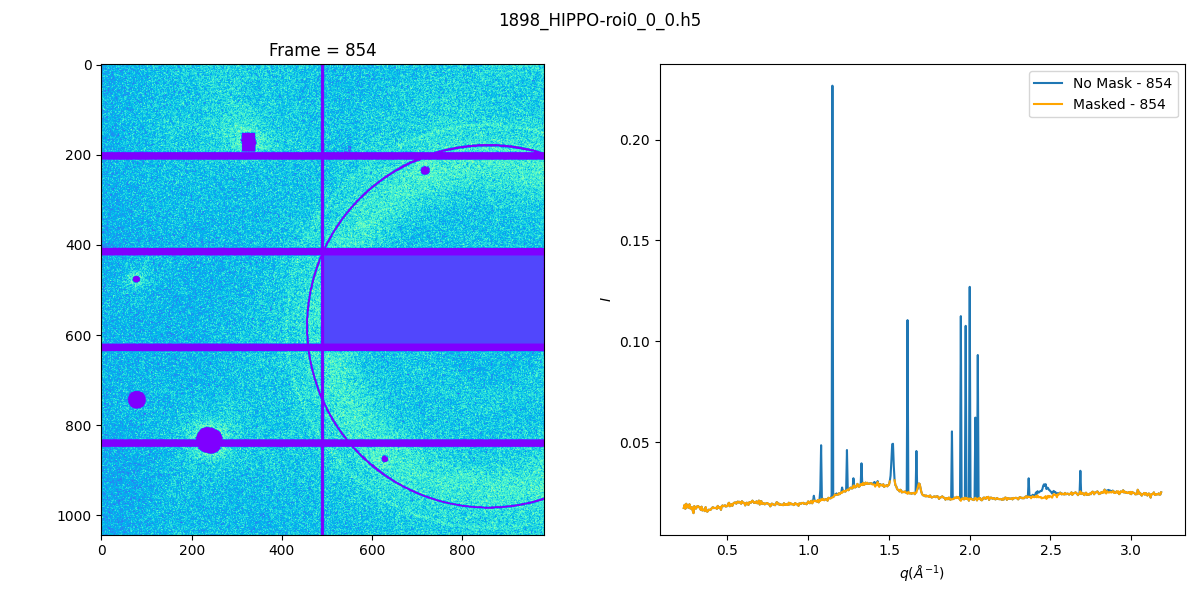

In [56]:
############### -------- configure patch size and copy the pathces tuplte to the next cell for computing 1-d averaging for all frames ------------- ################### (Independent Cell)
%matplotlib widget
frame = 854         # possible_bkg frame
file = "1898_HIPPO-roi0_0_0.h5"

dset_waxs_sum = loading_dset_waxs_sum(file, load_from = 'npz')
patches_arg = [
                             [[79,  743], 20 ],
                             [[312,152],[341,193]]
              ]

thr_args =  dset_waxs_sum, 0, 15634.00, 15344
args = (thr_args, patches_arg)

patching(file, frame, qgrid2, args=args, method = 'thr_rec_circ_patch', exp_folder = exp_folder);

In [3]:
##### --------- 1-d averaging after thresholding for one file - takes longer time  --------- (Independent Cell)
### spec
file = "1898_HIPPO-roi0_0_0.h5"
dset_waxs_sum = loading_dset_waxs_sum(file, load_from = 'npz')
patches_arg = [
                             [[79,  743], 20 ],
                             [[312,152],[350,193]]
              ]

thr_args =  dset_waxs_sum, 0, 15634.00, 15350
args = (thr_args, patches_arg)

### computation
masked_file = circ_avg_from_patches(file, qgrid2, args= args, method = 'thr_rec_circ_patch', exp_folder = exp_folder  )

1898_HIPPO-roi0_0_0_masked.h5 is being created in /Volumes/HDD/BNL-Data/Mar-2023/1898 ...
1898_HIPPO-roi0_0_0_masked.h5 copy is done
1898_HIPPO-roi0_0_0_masked.h5 Loading data into a numpy array started 
1898_HIPPO-roi0_0_0_masked.h5 Loading data into a numpy array finished in 60.60935624999999 seconds
1898_HIPPO-roi0_0_0_masked.h5 Patching Started 
1898_HIPPO-roi0_0_0_masked.h5 Patching finished in 45.30028229200002 seconds
1898_HIPPO-roi0_0_0_masked.h5 patched pilW2_image dataset creation staring ... 
1898_HIPPO-roi0_0_0_masked.h5 patched pilW2_image dataset creation finished in 114.196534708 seconds
Circular averaging starts now ... 


/Users/bashit.a/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/py4xs/hdf.py:301: RuntimeWarning: invalid value encountered in divide
  s0.data = d_tot/w_tot
/Users/bashit.a/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/py4xs/hdf.py:302: RuntimeWarning: invalid value encountered in divide
  s0.err = np.sqrt(e_tot)/w_tot
/Users/bashit.a/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/py4xs/hdf.py:281: RuntimeWarning: divide by zero encountered in divide
  wt = 1/d1.err[idx]**2
/Users/bashit.a/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/py4xs/hdf.py:282: RuntimeWarning: invalid value encountered in multiply
  d_tot[idx] += wt*d1.data[idx]
/Users/bashit.a/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/py4xs/hdf.py:283: RuntimeWarning: invalid value encountered in multiply
  e_tot[idx] += d1.err[idx]**2*wt**2
/Users/bashit.a/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/py4xs/hdf.py:301: RuntimeWarning: invalid value encountered in d

data received: sn=1898_HIPPO-roi0_0_0, fr1=0
data received: sn=1898_HIPPO-roi0_0_0, fr1=472
data received: sn=1898_HIPPO-roi0_0_0, fr1=944
data received: sn=1898_HIPPO-roi0_0_0, fr1=1416
data received: sn=1898_HIPPO-roi0_0_0, fr1=1888
data received: sn=1898_HIPPO-roi0_0_0, fr1=2360
data received: sn=1898_HIPPO-roi0_0_0, fr1=2832
data received: sn=1898_HIPPO-roi0_0_0, fr1=3304
1898_HIPPO-roi0_0_0_masked.h5 total 1-d averaging time 507.969151125 seconds


In [ ]:
# 1-d averaging after rectangular and/or circular patches for one file  (Independent Cell)
### spec
source_file = "2048_B8.h5"
patches = [
#                              [[800, 0], [980, 150]],
#                              [[245, 0], [385, 130]],
          ]

### computation
masked_file = circ_avg_from_patches(source_file, qgrid2, patches)

In [10]:
## patching information retrival from _masked.h5 file    (Independent Cell)
#specs
file   = "1898_HIPPO-roi0_0_0_masked.h5"
method = 'thr_rec_circ_patch'

# computation
try: 
    patches = get_patch_attributes(masked_file, method)   # 'thresholding'   'rec_circ_patch'   'thr_rec_circ_patch'
    print(patches)
except: 
    print(f'{file} does not have patches information on the processed folder')

1898_HIPPO-roi0_0_0_masked.h5 does not have patches information on the processed folder


In [20]:
### check config.json file integrity     (Independent Cell) - no error no problem
No_error_no_prb = get_json_str_data('sample-1898-march-2023-withthreshold.json');  # config-mar-2023-1898-withthreshold.json

In [ ]:
# 1-d averaging after patches for ALL files in the current directory   (Independent Cell)

# specs
data = get_json_str_data("config-mar-24-withthreshold.json")
method = 'thresholding'                                        # 'thresholding' or 'rec_circ_patch'

### do masking and 1-d averaging (Lin Yang's code by BNL used here for 1-d averaging)
files = []

for file in data['files']:
    source_file = file['name']
    try: 
        if method == 'rec_circ_patch':
            patches = file['patches']
            masked_file = circ_avg_from_patches(source_file, qgrid2, patches)
        elif method == 'thresholding': 
            patches = file['threshold']
            print(file, 'thresholded to -->', patches)
            masked_file = circ_avg_from_patches(source_file, qgrid2, args=tuple(patches), method = 'thresholding')  # args must be of tuple
    except: continue
    files.append((source_file, masked_file))

print(f'Successfully created (source file, masked file) \n\n')
[print(idx+1, '. ', s, '--->' ,t) for idx, (s,t) in enumerate(files)]
pass

In [42]:
# specs

data = get_json_str_data(os.path.join(cwd, "config-mar-2023-1898-withthreshold.json"))
method = 'thr_rec_circ_patch'                                      # 'thresholding' or 'rec_circ_patch' or 'thr_rec_circ_patch' 


### do masking and 1-d averaging (Lin Yang's code by BNL used here for 1-d averaging)
files = []

for file in data['files']:
    source_file = file['name']
    try: 
        if method == 'rec_circ_patch':
            patches = file['patches']
            print(source_file, 'patches to -->', patches)
            # masked_file = circ_avg_from_patches(source_file, qgrid2, patches) 
        elif method == 'thresholding': 
            patches = file['threshold']
            print(source_file, 'thresholded to -->', patches)
            # masked_file = circ_avg_from_patches(source_file, qgrid2, args=tuple(patches), method = 'thresholding')  # args must be of tuple
        elif method == 'thr_rec_circ_patch':
            if file['patches'] or file['threshold']:   # making sure either or both pathes and thresholding exists otherwise skip 
                dset_waxs_sum = loading_dset_waxs_sum(source_file, load_from = 'npz')
                patches_arg = file['patches']
                thr_args    =  dset_waxs_sum, *file['threshold']
                args = (thr_args, patches_arg)
                # print(source_file, 'thr_rec_circ_patch to -->', args)

                # masked_file = circ_avg_from_patches(file, qgrid2, args = args, method = 'thr_rec_circ_patch', exp_folder = exp_folder  )
            else:
                continue
    except: 
        continue
    files.append((source_file, masked_file))

print(f'Successfully created (source file, masked file) \n\n')
[print(idx+1, '. ', s, '--->' ,t) for idx, (s,t) in enumerate(files)]

Successfully created (source file, masked file) 


1 .  1898_CING-roi0_0_0.h5 ---> None
2 .  1898_HIPPO-roi0_0_0.h5 ---> None


[None, None]

Minimum, Maximum Iq : 0.0118, 0.0674


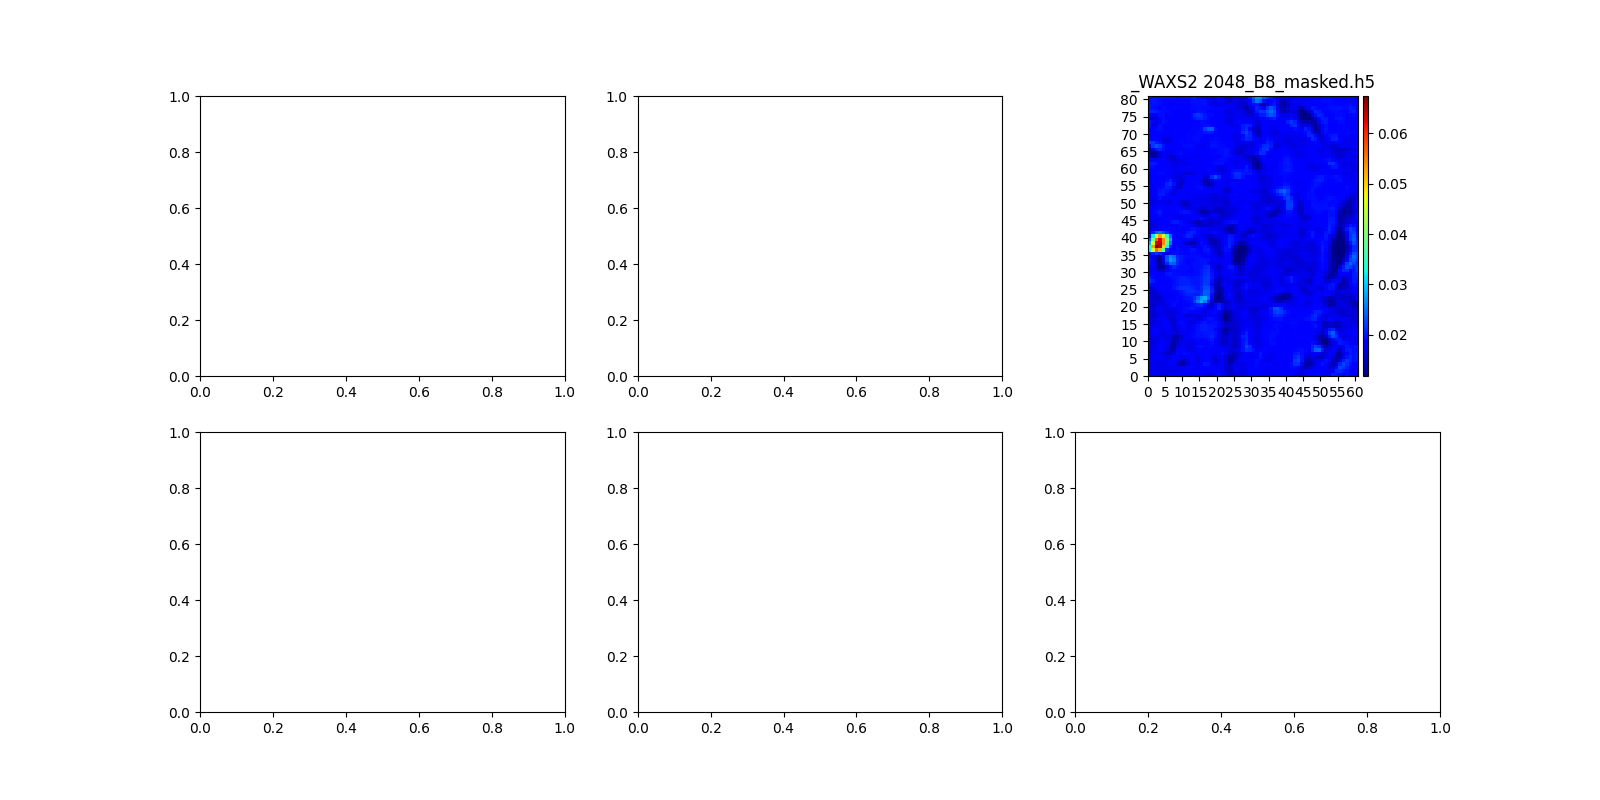

Minimum, Maximum Iq : 0.3227, 17.8944


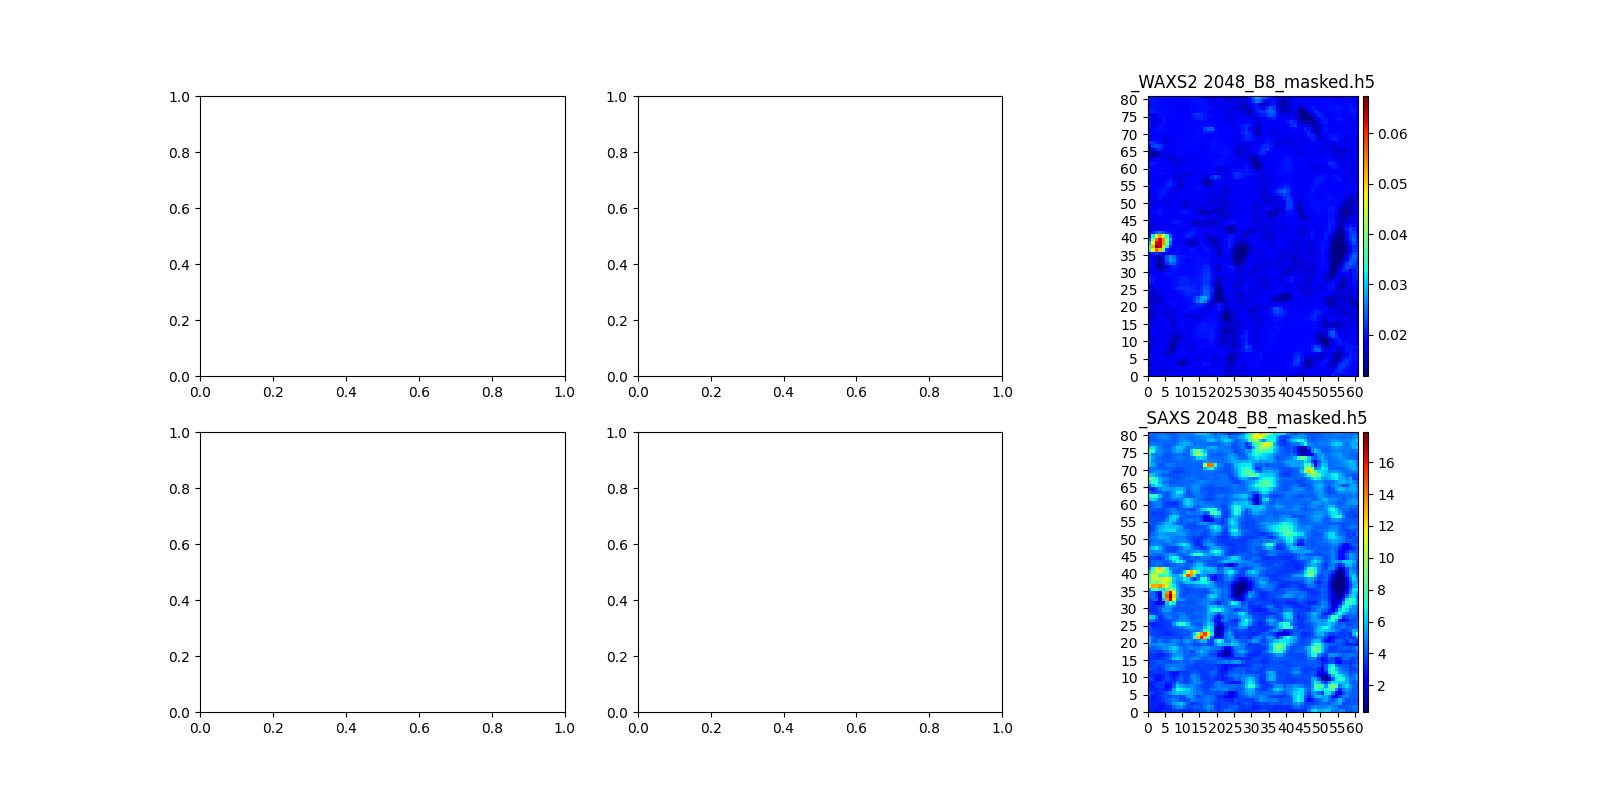

interactive(children=(IntSlider(value=0, continuous_update=False, description='Frame', max=4940), Output()), _…

In [233]:
### 1d circularly averaged data for masked file
%matplotlib widget
import ipywidgets   # from IPython.display import display; display(amp)
from IPython.display import display, clear_output

# anyinitialized masked_file will be removed beginning of the cell
try : del source_file
except NameError: pass

# specs 
source_file = "2048_B8.h5"                 # comment out to avoid plotting  # must input source file name   '1934_B8_masked.h5'
masked_file = "2048_B8_masked.h5"          # "2048_B8_masked.h5"
scattering = ('_SAXS', '_WAXS2',)
frames = None


# computation
Width, Height = width_height(masked_file)    # considering the fact that width and height is same for source and masked file
n_patterns = Width*Height

f,axs = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
# plot_heat_map_from_file(source_file, qgrid2, scatterings = (scattering[1],), cmap = 'viridis', args = (f, axs[0,1]))
plot_heat_map_from_file(masked_file, qgrid2, scatterings = (scattering[1],) , cmap = 'jet', args = (f, axs[0,2]), data_binning=False, bins = np.fromiter(drange(0, 0.04, 0.001), float) )  # discrete_cmap(N=5, base_cmap = 'cubehelix')     viridis
plot_heat_map_from_file(masked_file, qgrid2, scatterings = (scattering[0],) , cmap = 'jet', args = (f, axs[1,2]), data_binning=False, bins = np.fromiter(drange(0, 20, 0.5), float) )  # discrete_cmap(N=5, base_cmap = 'cubehelix')     viridis


def update_plot(frame):
    axs[0,0].clear()
    axs[1,0].clear()

    axs[0,0].set_yscale('log')
    axs[1,0].set_yscale('log')

    axs[0,0].set_xlabel('q'); axs[0,0].set_ylabel('log(I)');
    axs[1,0].set_xlabel('q'); axs[1,0].set_ylabel('log(I)');

    Iq_M_SAXS = read_Iq(masked_file, scattering[0])   # Source must be read even you do mask or not
    Iq_M_WAXS = read_Iq(masked_file, scattering[1])   # Source must be read even you do mask or not

    try:
        source_file
        if source_file ==  masked_file:
            axs[0,0].plot(qgrid2, Iq_S_WAXS[frame], label = f' Fr- {frame}');
            waxs_diff_image(masked_file, frame, f, axs[0,1])

            axs[1,0].plot(qgrid2, Iq_S_SAXS[frame], label = f' Fr- {frame}');
            saxs_diff_image(masked_file, frame, f, axs[1,1])

        else:
            Iq_S_SAXS = read_Iq(source_file, scattering[0])
            Iq_S_WAXS = read_Iq(source_file, scattering[1])
            
            axs[0,0].plot(qgrid2, Iq_S_WAXS[frame], label = f'Before Mask Fr- {frame}');
            axs[0,0].plot(qgrid2, Iq_M_WAXS[frame], label = f'After Mask Fr- {frame}'); 
            waxs_diff_image(masked_file, frame, f, axs[0,1])

            axs[1,0].plot(qgrid2, Iq_S_SAXS[frame], label = f'Before Mask Fr- {frame}');
            axs[1,0].plot(qgrid2, Iq_M_SAXS[frame], label = f'After Mask Fr- {frame}');
            saxs_diff_image(masked_file, frame, f, axs[1,1])

    except NameError:
        axs[0,0].plot(qgrid2, Iq_M_WAXS[frame], label = f' Fr- {frame}');
        waxs_diff_image(masked_file, frame, f, axs[0,1])

        axs[1,0].plot(qgrid2, Iq_M_SAXS[frame], label = f' Fr- {frame}');
        saxs_diff_image(masked_file, frame, f, axs[1,1])

    axs[0,0].legend()
    axs[1,0].legend()
    plt.suptitle(f'{masked_file}')
    plt.tight_layout()
    
if frames == None :
    frame = ipywidgets.IntSlider(min=0, max=n_patterns-1, value=0, description = "Frame", continuous_update=False)
else :
    frame = ipywidgets.SelectionSlider(value = frames[0], options = frames, continuous_update=False)

ipywidgets.interactive(update_plot, frame=frame)

In [478]:
### 2048_B8 SAXS and WAXS merging
%matplotlib widget

### specs
file               = '2048_B8.h5'
remove_points_SAXS = 8                         # last 8 points will be removed
mfs        = np.arange(0.01, 20, 0.01)         # look for multiplying factor for WAXS starting from >0

### computation
n_patterns = Iq_SAXS.shape[0]
mf_frames  = np.zeros((n_patterns,1))

scattering = ('_SAXS', '_WAXS2',)
Iq_SAXS    = read_Iq(file, scattering[0])
idx_SAXS_l, idx_SAXS_u, _ = valid_idx_search(qgrid2, Iq_SAXS, show_q = False)                           # get valid indices for WAXS data
idx_SAXS_u = idx_SAXS_u - remove_points_SAXS                                                            # remove last few points for SAXS data

Iq_WAXS    = read_Iq(file, scattering[1])
idx_WAXS_l, idx_WAXS_u, _ = valid_idx_search(qgrid2, Iq_WAXS, show_q = False)                           # get valid indices for WAXS data

qgrid2_common  = np.intersect1d(qgrid2[idx_SAXS_l: idx_SAXS_u], qgrid2[idx_WAXS_l: idx_WAXS_u])         # common qgrid points
n_common_qgrid = len(qgrid2_common)                                                                     # total number of common qgrids

print(qgrid2_common, len(qgrid2_common))

Iq = {'_SAXS'  :  np.ones((n_patterns , len(qgrid2)))  * np.nan ,   \
      '_WAXS2' :  np.ones((n_patterns , len(qgrid2)))  * np.nan ,   \
      'merged' :  np.ones((n_patterns , len(qgrid2)))  * np.nan     }

for frame in range(n_patterns):

    err = []
    for idx, mf in enumerate(mfs):
        Iq_SAXS_temp = Iq_SAXS[frame][ idx_SAXS_l : idx_SAXS_u]
        Iq_WAXS_temp = Iq_WAXS[frame][ idx_WAXS_l : idx_WAXS_u]

        y = Iq_SAXS_temp[len(Iq_SAXS_temp) - n_common_qgrid:] - mf * Iq_WAXS_temp[:n_common_qgrid]
        area = np.trapz(y, x = qgrid2_common)

        if area > 0:
            err.append(area)

        else:
            break

    err = np.array(err)
    mf_frames[frame] = mfs[err.argmin()]

    Iq['_SAXS'] [frame][ idx_SAXS_l : idx_SAXS_u] = Iq_SAXS_temp
    Iq['_WAXS2'][frame][ idx_WAXS_l : idx_WAXS_u] = Iq_WAXS_temp
    Iq['merged'][frame][ idx_SAXS_l : idx_WAXS_u] = np.concatenate((Iq_SAXS_temp[:-n_common_qgrid], mf_frames[frame]*Iq_WAXS_temp ))
    # print(err.argmin(), err.min(), mfs[err.argmin()])

def update_plot(frame):
    plt.cla()
    plt.plot((qgrid2[ idx_SAXS_l : idx_WAXS_u]), np.log(Iq['merged'][frame][ idx_SAXS_l : idx_WAXS_u]), label = f'Frame={frame}')
    plt.legend(loc = 'upper right')
    plt.show()
    
frame = ipywidgets.IntSlider(min=0, max=n_patterns-1, value=0, description = "Frame", continuous_update=False)
ipywidgets.interactive(update_plot, frame=frame)

[0.295 0.3   0.305 0.31  0.315 0.32  0.325 0.33 ] 8


interactive(children=(IntSlider(value=0, continuous_update=False, description='Frame', max=4940), Output()), _…

In [522]:
### writing to the same file 2048_B8.h5 and reading from the written file to verify
%matplotlib widget

file = '2048_B8.h5'
scatterings = ('_SAXS', '_WAXS2', 'merged')

# write to file
with h5py.File(file,'r+') as hdf:
    for scattering in scatterings:
        dataset_loc = f'2048_B8/processed/{scattering}'
        dset        = hdf.get(dataset_loc)
        dset        = np.array(dset)
        dset[:,0,:] = Iq[f'{scattering}']
        
        del hdf[dataset_loc]
        
        hdf.create_dataset(dataset_loc, data = dset)  

Iq_new = read_Iq(file, 'merged')
def update_plot(frame):
    plt.cla()
    plt.plot(qgrid2, np.log(Iq_new[frame,:]), label = f'Frame={frame}')
    plt.legend(loc = 'upper right')
    plt.show()
    
frame = ipywidgets.IntSlider(min=0, max=n_patterns-1, value=0, description = "Frame", continuous_update=False)
ipywidgets.interactive(update_plot, frame=frame)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Frame', max=4940), Output()), _…

In [97]:
### checking interpolation

%matplotlib widget

masked_file = '2428-roi0_0_0_masked.h5'  # '1898_EC-roi0_0_0_masked_intp.h5'  '1898_EC-roi0_0_0_masked.h5'
scattering  = 'merged' # 'merged'    '_WAXS2'

Iq = read_Iq(masked_file, scattering = scattering)
    
### plot figures
f,ax = plt.subplots(figsize=(16,8), num = masked_file)
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'

def update_plot(frame):

    ax.clear()
    ax.set_yscale('linear')
    ax.set_xlabel('q')
    ax.set_ylabel('log(Iq)')

    first_idx_not_nan = np.where(~np.isnan(Iq[frame])==True)[0][0]    # get the first indices of not nan value
    indx, A = interpolate_missing(Iq[frame][first_idx_not_nan:])
    B = np.concatenate((Iq[frame][:first_idx_not_nan], A))

    ax.plot(qgrid2, np.log(B))

    ax.scatter(qgrid2[indx+ first_idx_not_nan], np.log(B[indx+ first_idx_not_nan]), marker='.', color='red')
    f.suptitle(f'Frame = {frame}', fontsize=16)
    # plt.tick_params(left=False,
    #                 bottom=False,
    #                 labelleft=False,
    #                 labelbottom=False)
    plt.show()

Width, Height = width_height(masked_file)    # considering the fact that width and height is same for source and masked file
n_patterns = Width*Height
frame = ipywidgets.IntSlider(min=0, max=n_patterns-1, value=0, description = "Frame", continuous_update=False)
ipywidgets.interactive(update_plot, frame=frame)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Frame', max=1639), Output()), _…

In [2]:
### create new _masked_intp.h5 file for interpolation - 1-d with masking has to be done first
%matplotlib widget

# specs
masked_file = "1898_EC-roi1_0_0_masked.h5"

for masked_file in ["1971_Hippo-roi0_0_0_masked.h5", "1971_Hippo-roi1_0_0_masked.h5"] :
    ### computation
    ### copying new file with "_intp.h5"
    masked_file_new = masked_file.split(".h5")[0] + '_intp' + '.h5'
    print(f'{masked_file_new} is being created in {os.getcwd()} ...')
    shutil.copy2(masked_file, masked_file_new)       # create a new file
    print(f'{masked_file_new} copy is done')

    ### write Hdf5 file with interpolation
    scatterings = ('_WAXS2', 'merged')               # fix waxs2 and merged data
    directory = os.getcwd()
    Width, Height = width_height(masked_file_new)    # considering the fact that width and height is same for source and masked file
    n_patterns = Width*Height

    for scattering in scatterings:
        with h5py.File(os.path.join(directory, masked_file_new),'r+') as hdf:
            dset = hdf.get(f'{h5_top_group(masked_file_new)}/processed')              # Iq = hdf.get('2048_B16/processed')
            Iq = np.array(dset.get(scattering))                                       # Iq = np.array(2048_B16/processed/merged')

            # interpolation (3721, 690)
            Iq_new = np.zeros_like(Iq[:,0,:])
            for frame in range(n_patterns):
                Iq_one_fr = Iq[frame,0,:]
                first_idx_not_nan = np.where(~np.isnan(Iq_one_fr)==True)[0][0]    # get the first indices of not nan value
                indx, A = interpolate_missing(Iq_one_fr[first_idx_not_nan:])
                B = np.concatenate((Iq_one_fr[:first_idx_not_nan], A))
                Iq_new[frame] = B
            Iq[:,0,:] = Iq_new

            del dset[scattering]
            dset.create_dataset(scattering, data = Iq, compression="lzf")

1971_Hippo-roi0_0_0_masked_intp.h5 is being created in /Volumes/HDD/BNL-Data/Mar-2023/1971 ...
1971_Hippo-roi0_0_0_masked_intp.h5 copy is done
1971_Hippo-roi1_0_0_masked_intp.h5 is being created in /Volumes/HDD/BNL-Data/Mar-2023/1971 ...
1971_Hippo-roi1_0_0_masked_intp.h5 copy is done


In [96]:
['1898_EC-roi1_0_0_masked.h5', '1898_EC-roi0_0_0_masked.h5', '1898_HIPPO-roi0_0_0_masked.h5', '1898_HIPPO-roi1_0_0_masked.h5', '1898_HIPPO-roi2_0_0_masked.h5', '1898_PHG-roi1_0_0_masked.h5', '1898_V2-roi0_0_0_masked.h5', '1898_V2-roi1_0_0_masked.h5']
['1948_CING-roi0_0_0_masked.h5', '1948_HIPPO-roi1_0_0_masked.h5']
['1971_CING-roi0_0_0_masked.h5', "1971_Hippo-roi0_0_0_masked.h5", "1971_Hippo-roi1_0_0_masked.h5"]
['2068_HIPPO-roi0_0_0_masked.h5', '2068_PHG_2-roi0_0_0_masked.h5', '2068_PHG-roi0_0_0_masked.h5', '2068_V2-roi0_0_0_masked.h5', ]
['2191_EC-roi0_0_0_masked.h5', ]
['2048_B8_UNSTAINED-roi0_0_0_masked.h5', '2048_B8_UNSTAINED-roi1_0_0_masked.h5', '2428-roi1_0_0_masked.h5', ]

['2048_B8_UNSTAINED-roi0_0_0_masked.h5',
 '2048_B8_UNSTAINED-roi1_0_0_masked.h5',
 '2428-roi1_0_0_masked.h5']